# Kaggle Categorical Feature Encoding Challenge II

In [55]:
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [56]:
from xgboost.sklearn import XGBClassifier

In [57]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [58]:
def overview_table(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)
    return summary



Let's take an overview of the entire training set. From the output, it appears that for most of the columns, roughly 9% of values are missing. It's worth investigating further to get more information on these missing values

In [59]:
overview_table(train)

Dataset Shape: (600000, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,600000,0,1,2,19.19
1,bin_0,float64,17894,2,0,1,0,0.44
2,bin_1,float64,18003,2,0,1,1,0.69
3,bin_2,float64,17930,2,0,0,0,0.85
4,bin_3,object,18014,2,F,F,F,0.95
5,bin_4,object,18047,2,N,Y,N,1.00
6,nom_0,object,18252,3,Red,Red,Red,1.31
7,nom_1,object,18156,6,Trapezoid,Star,NaN,2.27
8,nom_2,object,18035,6,Hamster,Axolotl,Hamster,2.27
9,nom_3,object,18121,6,Russia,NaN,Canada,2.27


## Null Value Analysis

It appears that the majority of the time there is either no null or one null on any given given row. This eliminates the possibility that there are many rows where many of the features are null at once. It appears very inconsistent. I would still like to look further at the null's by column and see their impact on the predictor before taking any action on them.

missing_vals = train.isnull().sum(axis=1)
plt.hist(missing_vals, normed=True, bins=30)
plt.ylabel('Probability');
plt.title('Number of Nulls in a Row')
plt.show()

In [60]:
#train[train['bin_0'].notna()]['target'].value_counts()/len(train[train['bin_0'].notna()])
sel_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1','nom_2', 'nom_3', 'nom_4', 'nom_5', 
            'nom_6', 'nom_7', 'nom_8', 'nom_9','ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']
na_diff = []
col_diff = []
for col in sel_cols:
    col_diff.append(col)
    na_diff.append((train[train[col].notna()]['target'].value_counts()/len(train[train[col].notna()]))[0]-\
                   (train[train[col].isna()]['target'].value_counts()/len(train[train[col].isna()]))[0])

I want to now compare the null values against the non-nulls and see their impact for each feature against the predictor variable. It doesn't appear that any of the features having null values leads to a signficantly different result against the non-nulls. The most signficant deviation was day changing by 0.8% lower in the not-nas. This makes me more comfortable processing these na's without worrying about signficant impact

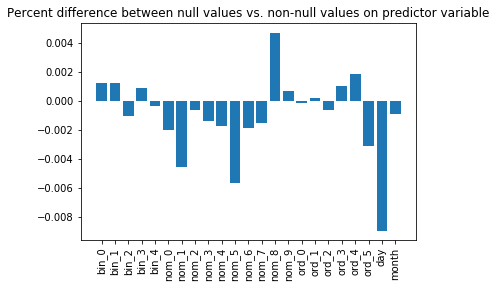

In [61]:
plt.bar(col_diff,na_diff)
plt.xticks(rotation='vertical')
plt.title("Percent difference between null values vs. non-null values on predictor variable")
plt.show()

## Feature Engineering

### Binary Features

For the binary features, I will change the missing values/na's to be -1, creating a category for themself as to not improperly weight the balance already existing in the feature.

In [62]:
#The first 3 bin features are already in numeric representation so I just need to apply fillna
train['bin_0'] = train['bin_0'].fillna(-1)
test['bin_0'] = test['bin_0'].fillna(-1)
train['bin_1'] = train['bin_1'].fillna(-1)
test['bin_1'] = test['bin_1'].fillna(-1)
train['bin_2'] = train['bin_2'].fillna(-1)
test['bin_2'] = test['bin_2'].fillna(-1)

In [63]:
repl = {'T' : 1, 'F' : 0, 'Y' : 1, 'N' : 0}
#map numeric values
train['bin_3'] = train['bin_3'].map(repl)
test['bin_3'] = test['bin_3'].map(repl)
train['bin_4'] = train['bin_4'].map(repl)
test['bin_4'] = test['bin_4'].map(repl)
#replace nas
train['bin_3'] = train['bin_3'].fillna(-1)
test['bin_3'] = test['bin_3'].fillna(-1)
train['bin_4'] = train['bin_4'].fillna(-1)
test['bin_4'] = test['bin_4'].fillna(-1)

### Low-Cardinality Nominal Features

In [64]:
#One hot encode nominal features
train = pd.get_dummies(train, columns=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],\
                          prefix=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],dummy_na=True,drop_first=True)
test = pd.get_dummies(test, columns=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],\
                          prefix=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],dummy_na=True,drop_first=True)

### High-Cardinality Nominal Features

In [65]:
high_card_nom = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

for col in high_card_nom:
    train[f'hash_{col}'] = train[col].apply( lambda x: hash(str(x)) % 5000 )
    test[f'hash_{col}'] = test[col].apply( lambda x: hash(str(x)) % 5000 )
    train = train.drop([col], axis = 1)
    test = test.drop([col], axis = 1)

It appears that the hashed value of an NA is 3898 as can be seen from the histogram below. I will evaluate whether or not this should be imputed with the mean value or it should be left in this position

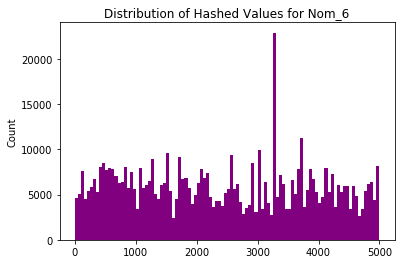

In [66]:
plt.hist(train['hash_nom_6'], bins = 100,color = 'purple')
plt.ylabel('Count');
plt.title('Distribution of Hashed Values for Nom_6')
plt.show()

### Low-Cardinality Ordinal Features

In [67]:
for col in ['ord_0','ord_1','ord_2']:
    print(train[col].unique())

[ 3.  1.  2. nan]
['Contributor' 'Grandmaster' nan 'Novice' 'Expert' 'Master']
['Hot' 'Warm' 'Freezing' 'Lava Hot' 'Cold' 'Boiling Hot' nan]


Impute values of NA with mean and add another column showing the NAs to preserve it.

In [68]:
map_tf = {True : 1, False : 0}

In [69]:
train['ord_0_nas'] = train['ord_0'].isna().map(map_tf)
train['ord_0'] = train['ord_0'].fillna(train['ord_0'].mean())
test['ord_0_nas'] = test['ord_0'].isna().map(map_tf)
test['ord_0'] = test['ord_0'].fillna(test['ord_0'].mean())

In [70]:
map_status = {'NA' : 0, 'Novice' : 1, 'Contributor' : 2, 'Expert' : 3, 'Master' : 4,'Grandmaster':5}

In [71]:
train['ord_1'] = train['ord_1'].fillna("NA").map(map_status)
test['ord_1'] = test['ord_1'].fillna("NA").map(map_status)

In [72]:
map_temp = {'NA' : 0, 'Freezing' : 1, 'Cold' : 2, 'Warm' : 3, 'Hot' : 4, 'Boiling Hot' : 5, 'Lava Hot' : 6}

In [73]:
train['ord_2'] = train['ord_2'].fillna("NA").map(map_temp)
test['ord_2'] = test['ord_2'].fillna("NA").map(map_temp)

We should just be able to use the ord() function for ord_3 and ord_4 to get an integer representing the Unicode code point. I will code nan to be 'm' as the midpoint of the alphabet

In [74]:
len(train)

600000

In [75]:
train = train[pd.notnull(train['ord_3'])]
train['ord_3'] = train['ord_3'].fillna('m')
train['ord_3'] = train['ord_3'].map(lambda x:ord(x))
test['ord_3'] = test['ord_3'].fillna('m')
test['ord_3'] = test['ord_3'].map(lambda x:ord(x))

In [76]:
len(train)

582084

In [77]:
train['ord_4'] = train['ord_4'].fillna('M')
train['ord_4'] = train['ord_4'].map(lambda x:ord(x))
test['ord_4'] = test['ord_4'].fillna('M')
test['ord_4'] = test['ord_4'].map(lambda x:ord(x))

There are multiple ways we could go about feature engineering ord_5. We could create two columns with the ord values for each. Or split them, get the ord values, then sum them together. I will try both and see which results in better accuracy. I mapped NAs to be 'ZZ' as it is close to the midpoint in the ord() values across uppercase and lowercase letters.

In [78]:
train['ord_5'] = train['ord_5'].fillna('ZZ')
test['ord_5'] = test['ord_5'].fillna('ZZ')

In [79]:
train['ord_5_left'] = train['ord_5'].map(lambda x:x[0])
train['ord_5_right'] = train['ord_5'].map(lambda x:x[1])

train = train.drop(['ord_5'], axis = 1)
test['ord_5_left'] = test['ord_5'].map(lambda x:x[0])
test['ord_5_right'] = test['ord_5'].map(lambda x:x[1])
test = test.drop(['ord_5'], axis = 1)

In [80]:
train['ord_5_left'] = train['ord_5_left'].map(lambda x:ord(x))
train['ord_5_right'] = train['ord_5_right'].map(lambda x:ord(x))
test['ord_5_left'] = test['ord_5_left'].map(lambda x:ord(x))
test['ord_5_right'] = test['ord_5_right'].map(lambda x:ord(x))

# When testing the combined vs. split, the split produced higher scores 

# train['ord_5_comb'] = train['ord_5_left'] + train['ord_5_right']
# test['ord_5_comb'] = test['ord_5_left'] + test['ord_5_right']
# train = train.drop(['ord_5_left','ord_5_right'], axis = 1)
# test = test.drop(['ord_5_left','ord_5_right'], axis = 1)

### Date Features 

These features are already in numeric representation but for cycle features we can apply a sin/cos function to them giving us two columns. It is interesting the the day column on has values up to 7 so for NAs i will represent them at 3.5

/home/cole-larrabee/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cole-larrabee/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


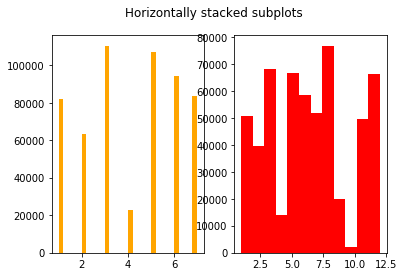

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 3]})
fig.suptitle('Horizontally stacked subplots')
ax1.hist(train['day'], bins = 30,color = 'orange')
ax2.hist(train['month'], bins = 12,color = 'red')
plt.show()

In [82]:
train['day'] = train['day'].fillna(3.5)
train['month'] = train['month'].fillna(6)
test['day'] = test['day'].fillna(3.5)
test['month'] = test['month'].fillna(6)

In [85]:
columns=['day','month']
for col in columns:
    train[col+'_sin']=np.sin((2*np.pi*train[col])/max(train[col]))
    train[col+'_cos']=np.cos((2*np.pi*train[col])/max(train[col]))
    test[col+'_sin']=np.sin((2*np.pi*train[col])/max(train[col]))
    test[col+'_cos']=np.cos((2*np.pi*train[col])/max(train[col]))
train=train.drop(columns,axis=1)
test=test.drop(columns,axis=1)

In [92]:
test['day_sin'] = test['day_sin'].fillna(test['day_sin'].mean())
test['day_cos'] = test['day_cos'].fillna(test['day_cos'].mean())
test['month_sin'] = test['month_sin'].fillna(test['month_sin'].mean())
test['month_cos'] = test['month_cos'].fillna(test['month_cos'].mean())

## Model Building

### Split Train to Train/Test

In [93]:
y = train['target']
df = train.drop(['id','target'], axis = 1)

In [94]:
X_train,X_test,y_train,y_test = train_test_split(df,y,test_size=0.2)

### Hyperparameter Tuning

In [95]:
from sklearn.model_selection import GridSearchCV
# grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} # l1 lasso l2 ridge
# clf=LogisticRegression()
# clf_cv=GridSearchCV(clf,grid,cv=10)
# clf_cv.fit(X_train,y_train)
# print("tuned hpyerparameters :(best parameters) ",clf_cv.best_params_)
# print("accuracy :",clf_cv.best_score_)

In [96]:
# xgb_grid = {"learning_rate"    : [0.05, 0.15, 0.20, 0.30 ] ,
#  "max_depth"        : [ 3,5, 8, 10, 25],
#  "min_child_weight" : [ 1, 3, 5, 7 ],
#  "gamma"            : [ 0.0, 0.2 , 0.4 ],
#  "colsample_bytree" : [ 0.3, 0.5 , 0.7 ],
#            "n_jobs" : [-1]}

Taking a subset of the data to allow the grid search to go quicker

In [97]:
# X_subset = X_train.sample(int((len(X_train)/25)), random_state=5)
# y_subset = y_train.sample(int((len(y_train)/25)), random_state=5)

In [98]:
# xgb=XGBClassifier()
# xgb_cv=GridSearchCV(xgb,xgb_grid, cv = 7)
# xgb_cv.fit(X_subset,y_subset)

In [99]:
# xgb_cv.best_params_

### XGBoost Classifier

In [100]:
xgb=XGBClassifier(colsample_bytree= 0.7,gamma= 0.4,learning_rate= 0.2,max_depth= 3, min_child_weight= 1,n_jobs= -1)

In [101]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.4,
       learning_rate=0.2, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [102]:
y_pred_xgb = xgb.predict(X_test)

In [103]:
from sklearn.metrics import roc_auc_score

In [104]:
roc_auc_score(y_test,y_pred_xgb)

0.5465595556835051

### Feature Importance

It appears from the feature importance, that the NA columns and the nom_3_Finland have an extremely low feature importance and could potentially be removed as they clearly have no predictive power

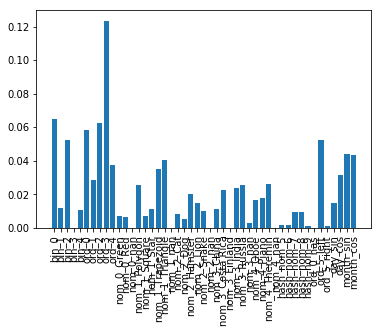

In [42]:
plt.bar(X_train.columns,xgb.feature_importances_)
plt.xticks(rotation='vertical')
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [43]:
# X_train = X_train.drop(['nom_0_nan','nom_1_nan','nom_2_nan','nom_3_Finland','nom_3_nan','ord_0_nas'], axis = 1)
# X_test = X_test.drop(['nom_0_nan','nom_1_nan','nom_2_nan','nom_3_Finland','nom_3_nan','ord_0_nas'], axis = 1)

In [44]:
# xgb.fit(X_train,y_train)

In [45]:
# y_pred_xgb = xgb.predict(X_test)

The ROC score was actually lower after removing the NAs so it would be best to just keep them in there.

In [46]:
# roc_auc_score(y_test,y_pred_xgb)

In [47]:
# plt.bar(X_train.columns,xgb.feature_importances_)
# plt.xticks(rotation='vertical')
# plt.rcParams['figure.figsize'] = [15, 5]
# plt.show()

### Log Regression 

In [48]:
clf = LogisticRegression(C=1, solver="lbfgs", max_iter=250, n_jobs=-1)

In [49]:
clf.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=250, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
y_pred = clf.predict(X_test)
y_proba_pred = clf.predict_proba(X_test)[:,1]

In [51]:
roc_auc_score(y_test,y_pred)

0.5002959327311712

XGBoost appears to be slightly better in this case to the logistic regression model so I will submit that

### Final Submission

In [105]:
test_id = test['id']
test = test.drop(['id'], axis = 1)
final_pred_log = clf.predict_proba(test)[:, 1]
final_pred_xgb = xgb.predict_proba(test)[:, 1]

In [106]:
pd.DataFrame({"id": test_id, "target": final_pred_xgb}).to_csv("submission.csv", index=False)